# LeNet5 _ ref1

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable

USE_CUDA = torch.cuda.is_available()
print(USE_CUDA)

device = torch.device('cuda:0' if USE_CUDA else 'cpu')
print('학습을 진행하는 기기:',device ,"\n")

batch_size = 100

# MNIST 데이터셋 로드
mnist_transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

train_set = torchvision.datasets.MNIST(
    root = './data/MNIST',
    train = True,
    download = True,
    transform = mnist_transform
)
test_set = torchvision.datasets.MNIST(
    root = './data/MNIST',
    train = False,
    download = True,
    transform = mnist_transform
)


# train_loader, test_loader 생성
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)

# input size를 알기 위해서
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)
print("train_set (shape) : ", example_data.shape)

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
print("test_loader (shape) : ",example_data.shape)

True
학습을 진행하는 기기: cuda:0 



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw

train_set (shape) :  torch.Size([100, 1, 32, 32])
test_loader (shape) :  torch.Size([100, 1, 32, 32])


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(2, stride=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1), ###
            nn.Tanh(),
            nn.AvgPool2d(2, stride=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh(),
        )
        self.f6 = nn.Linear(120, 84)
        self.fc = nn.Linear(84, 10) # RBF

        # if USE_CUDA:
        #     self.layers = self.layers.cuda()


    def forward(self, x):
        x = self.layers(x)
        x = x.view(-1, 120) # Hmm
        x = self.f6(x)
        x = self.fc(x)

        out = F.softmax(x, dim=1) # Gaussian connections
        return out


In [ ]:
model = Net().to(device)
  # Module.to() 메서드: 파라미터와 버퍼들을 옮김(또는 cast). device 파라미터에는 torch.device 객체가 들어감
print(model)

Net(
  (layers): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (7): Tanh()
  )
  (f6): Linear(in_features=120, out_features=84, bias=True)
  (fc): Linear(in_features=84, out_features=10, bias=True)
)


In [ ]:
### Ref. https://lynnshin.tistory.com/54

import torchsummary
print( torchsummary.summary(model, (1,32,32)) )

# import pytorch_model_summary
# print(pytorch_model_summary.summary(model, torch.zeros(1, 3, 32, 32), show_input=True))

# import torchinfo
# print( torchinfo.summary(model, (1, 1,32,32)) )

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
              Tanh-2            [-1, 6, 28, 28]               0
         AvgPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
              Tanh-5           [-1, 16, 10, 10]               0
         AvgPool2d-6             [-1, 16, 5, 5]               0
            Conv2d-7            [-1, 120, 1, 1]          48,120
              Tanh-8            [-1, 120, 1, 1]               0
            Linear-9                   [-1, 84]          10,164
           Linear-10                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.11
Params size (MB): 0.24
Estimated Tot

In [ ]:
model = Net().to(device)
epochs = 20

learning_rate=0.01

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

train_losses = []
train_acc = []

test_loss = []
test_acc = []
####################
# data, y = next(iter(train_loader))
for epoch in range(epochs) :
  tr_loss = []
  tr_acc = []
  for batch_idx, (data, y) in enumerate(train_loader):

    ### DataLoader에서 불러온 데이터셋을 가져온 뒤 디바이스에 올리기
    data = data.to(device)
    y = y.to(device)

    # data = Variable(data.view(-1,28 * 28))
    y = Variable(y.view(-1))

    optimizer.zero_grad()
    y_pred = model(data)
    y_lb = torch.argmax(y_pred,dim=1)

    loss = loss_fn(y_pred, y)
    loss.backward()
    optimizer.step()

    tr_loss.append(loss.item())
    tr_acc.append( (y_lb.eq(y.view_as(y_lb)).sum() / len(y_lb) ).item() )

  tr_loss = sum(tr_loss)/len(tr_loss)
  tr_acc = sum(tr_acc)/len(tr_acc)

  train_losses.append( tr_loss )
  train_acc.append( tr_acc  )
  print('Train Epoch:{} \tLoss: {:.4f}\tAcc: {:.6f}'.format(epoch, tr_loss, tr_acc ) )


  ts_loss = []
  ts_acc = []
  with torch.no_grad():
    for data, y in test_loader:
      data = data.to(device)
      y = y.to(device)

      y = Variable(y.view(-1))
      y_pred = model(data)
      y_lb = torch.argmax(y_pred,dim=1)

      loss = loss_fn(y_pred, y)
      ts_loss.append(loss.item())
      ts_acc.append( (y_lb.eq(y.view_as(y_lb)).sum() / len(y_lb) ).item() )

  ts_loss = sum(ts_loss)/len(ts_loss)
  ts_acc = sum(ts_acc)/len(ts_acc)

  test_loss.append( ts_loss )
  test_acc.append( ts_acc  )
  print('Test set:\tLoss: {:.4f}\tAcc: {:.6f}\n'.format( ts_loss, ts_acc ))

Train Epoch:0 	Loss: 2.0281	Acc: 0.468583
Test set:	Loss: 1.6368	Acc: 0.871600

Train Epoch:1 	Loss: 1.5862	Acc: 0.896700
Test set:	Loss: 1.5535	Acc: 0.920900

Train Epoch:2 	Loss: 1.5474	Acc: 0.923867
Test set:	Loss: 1.5328	Acc: 0.935700

Train Epoch:3 	Loss: 1.5292	Acc: 0.939783
Test set:	Loss: 1.5195	Acc: 0.947800

Train Epoch:4 	Loss: 1.5170	Acc: 0.950650
Test set:	Loss: 1.5094	Acc: 0.956700

Train Epoch:5 	Loss: 1.5081	Acc: 0.958917
Test set:	Loss: 1.5022	Acc: 0.962900

Train Epoch:6 	Loss: 1.5017	Acc: 0.964583
Test set:	Loss: 1.4968	Acc: 0.968600

Train Epoch:7 	Loss: 1.4968	Acc: 0.969033
Test set:	Loss: 1.4928	Acc: 0.972700

Train Epoch:8 	Loss: 1.4930	Acc: 0.972617
Test set:	Loss: 1.4899	Acc: 0.975300

Train Epoch:9 	Loss: 1.4899	Acc: 0.975517
Test set:	Loss: 1.4877	Acc: 0.976200

Train Epoch:10 	Loss: 1.4874	Acc: 0.977717
Test set:	Loss: 1.4862	Acc: 0.977200

Train Epoch:11 	Loss: 1.4853	Acc: 0.979667
Test set:	Loss: 1.4851	Acc: 0.977800

Train Epoch:12 	Loss: 1.4836	Acc: 0.98

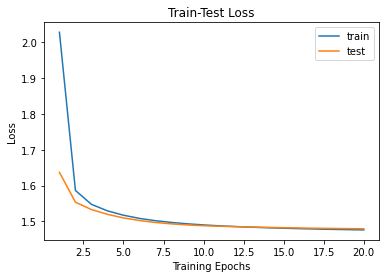

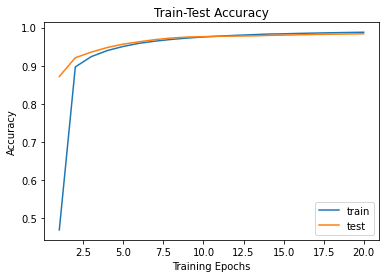

In [ ]:
import matplotlib.pyplot as plt

plt.title("Train-Test Loss")
plt.plot(range(1,epochs+1),train_losses,label="train")
plt.plot(range(1,epochs+1),test_loss,label="test")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()


plt.title("Train-Test Accuracy")
plt.plot(range(1,epochs+1),train_acc,label="train")
plt.plot(range(1,epochs+1),test_acc,label="test")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# Custom Conolution layer (Ref Code)

In [ ]:
### From JS Code
class Subsample(nn.Module):
    def __init__(self,f_count):
        super(Subsample, self).__init__()
        # self.S = nn.AvgPool2d(2, stride=2, divisor_override=1)
        self.weight = nn.Parameter(torch.Tensor(1,f_count,1,1))
        self.bias = nn.Parameter(torch.Tensor(1,f_count,1,1))
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.normal_(self.weight, 0, 1)
        nn.init.normal_(self.bias, 0, 1)

    def forward(self, x):
        x = F.avg_pool2d(x,2,2, divisor_override=1)
        x = x*self.weight+self.bias
        return x

class MaskedConv2d(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size,mask):
        super(MaskedConv2d, self).__init__()
        self.fm = mask
        self.in_channels=in_channels
        self.out_channels=out_channels
        self.kernel_size=kernel_size

        # self.C = nn.Conv2d(in_channels=self.in_channels,out_channels=self.out_channels,kernel_size=kernel_size)
        # print()

        self.module_list = nn.ModuleList()
        for h in range(self.in_channels):
            self.module_list.append(MaskedConv2dSingle(self.kernel_size,self.fm[h,:]))

        self.bias = nn.Parameter(torch.Tensor(1,self.out_channels,1,1))
        # nn.init.normal_(self.bias, 0, 1)
        self.weight =nn.Parameter(torch.Tensor(0))

    def forward(self, x):
        out = torch.zeros((x.shape[0],self.out_channels,10,10)).cuda()
        for ch in range(self.in_channels):
            out[:,self.fm[ch,:]==1,:,:] = self.module_list[ch](x[:,[ch],:,:])
        x = out+self.bias
        # x = out
        return x

class MaskedConv2dSingle(nn.Module):
    def __init__(self,kernel_size,singlemask):
        super(MaskedConv2dSingle, self).__init__()
        self.singlemask = singlemask
        self.C = nn.Conv2d(in_channels=1,out_channels=int(singlemask.sum()),kernel_size=kernel_size,bias=False)

    def forward(self, x):
        x = self.C(x)
        return x

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.C1 = nn.Conv2d(in_channels=1,out_channels=6,kernel_size=5)
        self.S1 = Subsample(6)
        self.fm = torch.FloatTensor([[1,0,0,0,1,1,1,0,0,1,1,1,1,0,1,1],
                    [1,1,0,0,0,1,1,1,0,0,1,1,1,1,0,1],
                    [1,1,1,0,0,0,1,1,1,0,0,1,0,1,1,1],
                    [0,1,1,1,0,0,1,1,1,1,0,0,1,0,1,1],
                    [0,0,1,1,1,0,0,1,1,1,1,0,1,1,0,1],
                    [0,0,0,1,1,1,0,0,1,1,1,1,0,1,1,1]]).cuda()
        # self.fm = torch.FloatTensor([[1,0,0,0,1,1,1,0,0,1,1,1,1,0,1,1],
        #             [1,1,0,0,0,1,1,1,0,0,1,1,1,1,0,1],
        #             [1,1,1,0,0,0,1,1,1,0,0,1,0,1,1,1],
        #             [0,1,1,1,0,0,1,1,1,1,0,0,1,0,1,1],
        #             [0,0,1,1,1,0,0,1,1,1,1,0,1,1,0,1],
        #             [0,0,0,1,1,1,0,0,1,1,1,1,0,1,1,1]]).cuda()

        self.C3_mask = MaskedConv2d(in_channels=6,out_channels=16,kernel_size=5,mask=self.fm)
        # self.C3 = nn.Conv2d(in_channels=6,out_channels=16,kernel_size=5)

        self.S4 = Subsample(16)
        self.C5 = nn.Conv2d(in_channels=16,out_channels=120,kernel_size=5)
        self.F6 = nn.Linear(120,84)
        self.output = torch_rbf.RBF(84, 10, torch_rbf.linear,num_weights=np.array(num_list))


    def Atanh(self,x):
        return nn.Tanh()(x*2/3)*1.7159

    def forward(self, x):
        x = self.C1(x)
        x = self.Atanh(x)
        x = self.S1(x)
        x = self.Atanh(x)
        x = self.C3_mask(x)
        x = self.Atanh(x)
        x = self.S4(x)
        x = self.Atanh(x)
        x = self.C5(x).view((-1,120))
        x = self.Atanh(x)F
        x = self.F6(x)
        x = self.Atanh(x)
        x = self.output(x)
        return x

    def Loss(self,y_ture,y_pred,j=1.):
        tag_onehot = nn.functional.one_hot(y_ture)
        SE = tag_onehot*y_pred
        competive = torch.exp(-y_pred).sum(1)+torch.exp(torch.tensor(j))
        loss = (SE.sum(1)+competive).mean()
        return loss

    def fit(self,EPOCHS,lr):
        optimizer = optim.AdamW(self.parameters(), lr=lr)
        loss_track = []

        for e in range(EPOCHS):
            running_loss = []
            running_acc = []
            t = time.time()
            for data,target in data_loader:
                if USE_CUDA:
                    data = data.cuda()
                    target = target.cuda()
                N = data.size(0)
                # in your training loop:
                optimizer.zero_grad()   # zero the gradient buffers
                output = self(data)
                loss = self.Loss(target,output)
                # loss = criterion(output, target)
                # regularity =  torch.norm(net.weight, p=p)
                loss.backward()
                optimizer.step()    # Does the update

                predicted = torch.argmin(output.data,1)
                running_loss.append(loss.item())
                running_acc.append((predicted==target).sum().item() * (1/N))

            batch_loss = np.mean(running_loss)
            batch_acc = np.mean(running_acc)
            print('epoch:{:04d}  loss:{:.3f}  acc:{:.3f}'.format(e,batch_loss,batch_acc))
            print(time.time() - t)
            loss_track.append(batch_loss)


In [ ]:
class Myconv2D(torch.autograd.Function):

    # Note that both forward and backward are @staticmethods
    @staticmethod
    # bias is an optional argument
    def forward(ctx, input, weight, bias=None):
        ctx.save_for_backward(input, weight, bias)

        # input dim [batch_size, channels, height, width]

        batch_size = len(input)
        channels = input[0][0]
        h, w = input[0][0][0], input [0][0][0]
        image =  torch.tensor(batch_size, channels, h, w) # input image
        #print (image)
        #print (image.size())
        #print (image[0])

        kh, kw = 3, 3# kernel size
        dh, dw = 2, 2 # stride

        filt = nn.parameter(channels, kh, kw) # filter (create this as nn.Parameter if you want to train it)
        #print (filt)
        patches = image.unfold(2, kh, dh).unfold(3, kw, dw)
        #print(patches.shape)
        patches = patches.contiguous().view(batch_size, channels, -1, kh, kw)
        #print(patches.shape)
        patches = patches.permute(0, 2, 1, 3, 4)
        patches = patches.view(-1, channels, kh, kw)
        #print (patches.shape)
        #print ("Filter shape",filt.shape)
        #print(patches)
        #print (patches,"\n","\n","\n",filt)
        #print ("Builtin multiplication")

        dummy = patches

        patches = patches * filt # same is done below with 4 nested loops with custom operation
        #print(patches)
        #print ("Custom Multiplication starts here:")
        #print(patches[0][0][0][0])
        #print(filt)

        for b in range(batch_size* int(h/3)* int(h/3)):
            for c in range(channels):
                for height in range(kh):
                    for width in range(kw):
                        patches[b][c][height][width]   = \
                        dummy[b][c][height][width] * filt[c][height][width]  replace this multiply(*) with my function (mymult(num1,num2))


        #print(patches)
        patches = patches.sum(1) # previous and this patch are same what is it doing
        #print (patches)
        output = patches # is it right ?
        if bias is not None:
            output += bias.unsqueeze(0).expand_as(output)
        return output

    # This function has only a single output, so it gets only one gradient
    @staticmethod
    def backward(ctx, grad_output):
        # This is a pattern that is very convenient - at the top of backward
        # unpack saved_tensors and initialize all gradients w.r.t. inputs to
        # None. Thanks to the fact that additional trailing Nones are
        # ignored, the return statement is simple even when the function has
        # optional inputs.
        input, weight, bias = ctx.saved_tensors
        grad_input = grad_weight = grad_bias = None


In [ ]:
# https://discuss.pytorch.org/t/custom-convolution-layer/45979/7

class MyConv2d(nn.Module):
    def __init__(self, n_channels, out_channels, kernel_size, dilation=1, padding=0, stride=1):
        super(MyConv2d, self).__init__()

        self.kernel_size = (kernel_size, kernel_size)
        self.kernal_size_number = kernel_size * kernel_size
        self.out_channels = out_channels
        self.dilation = (dilation, dilation)
        self.padding = (padding, padding)
        self.stride = (stride, stride)
        self.n_channels = n_channels
        self.weights = nn.Parameter(torch.Tensor(self.out_channels, self.n_channels, self.kernal_size_number))

    def forward(self, x):
        width = self.calculateNewWidth(x)
        height = self.calculateNewHeight(x)
        windows = self.calculateWindows(x)

        result = torch.zeros(
            [x.shape[0] * self.out_channels, width, height], dtype=torch.float32, device=device
        )

        for channel in range(x.shape[1]):
            for i_convNumber in range(self.out_channels):
                xx = torch.matmul(windows[channel], self.weights[i_convNumber][channel])
                xx = xx.view(-1, width, height)
                result[i_convNumber * xx.shape[0] : (i_convNumber + 1) * xx.shape[0]] += xx

        result = result.view(x.shape[0], self.out_channels, width, height)
        return result

    def calculateWindows(self, x):
        windows = F.unfold(
            x, kernel_size=self.kernel_size, padding=self.padding, dilation=self.dilation, stride=self.stride
        )

        windows = windows.transpose(1, 2).contiguous().view(-1, x.shape[1], self.kernal_size_number)
        windows = windows.transpose(0, 1)

        return windows

    def calculateNewWidth(self, x):
        return (
            (x.shape[2] + 2 * self.padding[0] - self.dilation[0] * (self.kernel_size[0] - 1) - 1)
            // self.stride[0]
        ) + 1

    def calculateNewHeight(self, x):
        return (
            (x.shape[3] + 2 * self.padding[1] - self.dilation[1] * (self.kernel_size[1] - 1) - 1)
            // self.stride[1]
        ) + 1


# device = 'cpu'
# conv = MyConv2d(3, 1, 3)
# x = torch.randn(1, 3, 24, 24)
# out = conv(x)
# out.mean().backward()
# print(conv.weights.grad)




##############

class MyConv2d(nn.Module):
    def __init__(self, n_channels, out_channels, kernel_size, dilation=1, padding=0, stride=1):
        super(MyConv2d, self).__init__()

        self.kernel_size = (kernel_size, kernel_size)
        self.kernal_size_number = kernel_size * kernel_size
        self.out_channels = out_channels
        self.dilation = (dilation, dilation)
        self.padding = (padding, padding)
        self.stride = (stride, stride)
        self.n_channels = n_channels
        self.weights = nn.Parameter(torch.Tensor(self.out_channels, self.n_channels, self.kernal_size_number))

    def forward(self, x):
        width = self.calculateNewWidth(x)
        height = self.calculateNewHeight(x)
        windows = self.calculateWindows(x)

        result = torch.zeros(
            [x.shape[0] * self.out_channels, width, height], dtype=torch.float32, device=device
        )

        for channel in range(x.shape[1]):
            for i_convNumber in range(self.out_channels):
                xx = torch.matmul(windows[channel], self.weights[i_convNumber][channel])
                xx = xx.view(-1, width, height)
                result[i_convNumber * xx.shape[0] : (i_convNumber + 1) * xx.shape[0]] += xx

        result = result.view(x.shape[0], self.out_channels, width, height)
        return result

    def calculateWindows(self, x):
        windows = F.unfold(
            x, kernel_size=self.kernel_size, padding=self.padding, dilation=self.dilation, stride=self.stride
        )

        windows = windows.transpose(1, 2).contiguous().view(-1, x.shape[1], self.kernal_size_number)
        windows = windows.transpose(0, 1)

        return windows

    def calculateNewWidth(self, x):
        return (
            (x.shape[2] + 2 * self.padding[0] - self.dilation[0] * (self.kernel_size[0] - 1) - 1)
            // self.stride[0]
        ) + 1

    def calculateNewHeight(self, x):
        return (
            (x.shape[3] + 2 * self.padding[1] - self.dilation[1] * (self.kernel_size[1] - 1) - 1)
            // self.stride[1]
        ) + 1

    def get_weights(self):
        kernal_size = int(math.sqrt(self.kernal_size_number))
        return nn.Parameter(self.weights.view(self.out_channels, self.n_channels, kernal_size, kernal_size))

##############

# LeNet5_tmp

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable

USE_CUDA = torch.cuda.is_available()
print(USE_CUDA)

device = torch.device('cuda:0' if USE_CUDA else 'cpu')
print('학습을 진행하는 기기:',device ,"\n")

batch_size = 100

# MNIST 데이터셋 로드
mnist_transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

train_set = torchvision.datasets.MNIST(
    root = './data/MNIST',
    train = True,
    download = True,
    transform = mnist_transform
)
test_set = torchvision.datasets.MNIST(
    root = './data/MNIST',
    train = False,
    download = True,
    transform = mnist_transform
)


# train_loader, test_loader 생성
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)

# input size를 알기 위해서
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)
print("train_set (shape) : ", example_data.shape)

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
print("test_loader (shape) : ",example_data.shape)

True
학습을 진행하는 기기: cuda:0 



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw

train_set (shape) :  torch.Size([100, 1, 32, 32])
test_loader (shape) :  torch.Size([100, 1, 32, 32])


In [ ]:
# class lenet_Conv2d(nn.Module):
#     def __init__(self, n_channels, out_channels, kernel_size):
#         super(lenet_Conv2d, self).__init__()
#         self.in_channels = in_channels
#         self.out_channels = out_channels
#         self.kernel_size = (kernel_size, kernel_size)
#         self.kernal_size_number = kernel_size * kernel_size

#         self.weights = nn.Parameter(torch.Tensor(self.out_channels, self.in_channels, self.kernal_size_number))
#         self.bias = nn.Parameter(torch.Tensor(1, self.out_channels, 1, 1))

#         self.reset_parameters()

#     def forward(self, x):
#       width = self.calculateNewWidth(x)
#       height = self.calculateNewHeight(x)
#       windows = self.calculateWindows(x)

#       result = torch.zeros(
#           [x.shape[0] * self.out_channels, width, height], dtype=torch.float32, device=device
#       )

#       for channel in range(x.shape[1]):
#           for i_convNumber in range(self.out_channels):
#               xx = torch.matmul(windows[channel], self.weights[i_convNumber][channel])
#               xx = xx.view(-1, width, height)
#               result[i_convNumber * xx.shape[0] : (i_convNumber + 1) * xx.shape[0]] += xx

#       result = result.view(x.shape[0], self.out_channels, width, height)
#       return result

#     def calculateWindows(self, x):
#         windows = F.unfold(
#             x, kernel_size=self.kernel_size, padding=self.padding, dilation=self.dilation, stride=self.stride
#         )

#         windows = windows.transpose(1, 2).contiguous().view(-1, x.shape[1], self.kernal_size_number)
#         windows = windows.transpose(0, 1)

#         return windows

#     def calculateNewWidth(self, x):
#         return (
#             (x.shape[2] + 2 * self.padding[0] - self.dilation[0] * (self.kernel_size[0] - 1) - 1)
#             // self.stride[0]
#         ) + 1

#     def calculateNewHeight(self, x):
#         return (
#             (x.shape[3] + 2 * self.padding[1] - self.dilation[1] * (self.kernel_size[1] - 1) - 1)
#             // self.stride[1]
#         ) + 1

#     def reset_parameters(self):
#         self.weight.weight.data.fill_(1.0)
#         self.bias.data.zero_()

In [ ]:
  # self.fm = torch.FloatTensor([[1,0,0,0,1,1,1,0,0,1,1,1,1,0,1,1],
  #             [1,1,0,0,0,1,1,1,0,0,1,1,1,1,0,1],
  #             [1,1,1,0,0,0,1,1,1,0,0,1,0,1,1,1],
  #             [0,1,1,1,0,0,1,1,1,1,0,0,1,0,1,1],
  #             [0,0,1,1,1,0,0,1,1,1,1,0,1,1,0,1],
  #             [0,0,0,1,1,1,0,0,1,1,1,1,0,1,1,1]]).cuda()

class lenet_Conv2d(nn.Module):
    def __init__(self, n_channels, out_channels, kernel_size):
        super(lenet_Conv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = (kernel_size, kernel_size)
        self.kernal_size_number = kernel_size * kernel_size

        self.weights = nn.Parameter(torch.Tensor(self.out_channels, self.in_channels, self.kernal_size_number))
        self.bias = nn.Parameter(torch.Tensor(1, self.out_channels, 1, 1))

        self.reset_parameters()

    def forward(self, x):
      width = self.calculateNewWidth(x)
      height = self.calculateNewHeight(x)
      windows = self.calculateWindows(x)

      result = torch.zeros(
          [x.shape[0] * self.out_channels, width, height], dtype=torch.float32, device=device
      )

      for channel in range(x.shape[1]):
          for i_convNumber in range(self.out_channels):
              xx = torch.matmul(windows[channel], self.weights[i_convNumber][channel])
              xx = xx.view(-1, width, height)
              result[i_convNumber * xx.shape[0] : (i_convNumber + 1) * xx.shape[0]] += xx

      result = result.view(x.shape[0], self.out_channels, width, height)
      return result

    def calculateWindows(self, x):
        windows = F.unfold(
            x, kernel_size=self.kernel_size, padding=self.padding, dilation=self.dilation, stride=self.stride
        )

        windows = windows.transpose(1, 2).contiguous().view(-1, x.shape[1], self.kernal_size_number)
        windows = windows.transpose(0, 1)

        return windows

    def calculateNewWidth(self, x):
        return (
            (x.shape[2] + 2 * self.padding[0] - self.dilation[0] * (self.kernel_size[0] - 1) - 1)
            // self.stride[0]
        ) + 1

    def calculateNewHeight(self, x):
        return (
            (x.shape[3] + 2 * self.padding[1] - self.dilation[1] * (self.kernel_size[1] - 1) - 1)
            // self.stride[1]
        ) + 1

    def reset_parameters(self):
        self.weight.weight.data.fill_(1.0)
        self.bias.data.zero_()

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(2, stride=2),
            # nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1), ### lenet_Conv2d
            lenet_Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.Tanh(),
            nn.AvgPool2d(2, stride=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh(),
        )
        self.f6 = nn.Linear(120, 84)
        self.fc = nn.Linear(84, 10) ### RBF
        # RBF(in_features=84, out_features=10),


    def forward(self, x):
        x = self.layers(x)
        x = x.view(-1, 120) # Hmm
        x = self.f6(x)
        x = self.fc(x)

        out = F.softmax(x, dim=1) # Gaussian connections
        return out

In [ ]:
model = Net().to(device)
print(model)

Net(
  (layers): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): select_conv2d()
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (7): Tanh()
  )
  (f6): Linear(in_features=120, out_features=84, bias=True)
  (fc): Linear(in_features=84, out_features=10, bias=True)
)


In [ ]:
import torchsummary
print( torchsummary.summary(model, (1,32,32)) )

# import pytorch_model_summary
# print(pytorch_model_summary.summary(model, torch.zeros(1, 3, 32, 32), show_input=True))

# import torchinfo
# print( torchinfo.summary(model, (1, 1,32,32)) )

RuntimeError: ignored

In [ ]:
def loss_fn_(y_pred, y):
    # |x_hat| = (batch_size, dim)
    # |x| = (batch_size, dim)
    y = ((x - x_hat)**2).mean()

    return y

In [ ]:
model = Net().to(device)
epochs = 20

learning_rate=0.01

loss_fn = nn.CrossEntropyLoss() ###
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)


In [ ]:
tr_loss = []
tr_acc = []

data, y = next(iter(train_loader))
### DataLoader에서 불러온 데이터셋을 가져온 뒤 디바이스에 올리기
data = data.to(device)
y = y.to(device)

# data = Variable(data.view(-1,28 * 28))
y = Variable(y.view(-1))

optimizer.zero_grad()
y_pred = model(data)
y_lb = torch.argmax(y_pred,dim=1)

loss = loss_fn(y_pred, y)
loss.backward()
optimizer.step()

tr_loss.append(loss.item())
tr_acc.append( (y_lb.eq(y.view_as(y_lb)).sum() / len(y_lb) ).item() )

tr_loss = sum(tr_loss)/len(tr_loss)
tr_acc = sum(tr_acc)/len(tr_acc)
print('Train Epoch: \tLoss: {:.4f}\tAcc: {:.6f}'.format( tr_loss, tr_acc ) )


RuntimeError: ignored

In [ ]:
model = Net().to(device)
epochs = 20

learning_rate=0.01

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)


In [ ]:
train_losses = []
train_acc = []

test_loss = []
test_acc = []
####################
# data, y = next(iter(train_loader))
for epoch in range(epochs) :
  tr_loss = []
  tr_acc = []
  for batch_idx, (data, y) in enumerate(train_loader):

    ### DataLoader에서 불러온 데이터셋을 가져온 뒤 디바이스에 올리기
    data = data.to(device)
    y = y.to(device)

    # data = Variable(data.view(-1,28 * 28))
    y = Variable(y.view(-1))

    optimizer.zero_grad()
    y_pred = model(data)
    y_lb = torch.argmax(y_pred,dim=1)

    loss = loss_fn(y_pred, y)
    loss.backward()
    optimizer.step()

    tr_loss.append(loss.item())
    tr_acc.append( (y_lb.eq(y.view_as(y_lb)).sum() / len(y_lb) ).item() )

  tr_loss = sum(tr_loss)/len(tr_loss)
  tr_acc = sum(tr_acc)/len(tr_acc)

  train_losses.append( tr_loss )
  train_acc.append( tr_acc  )
  print('Train Epoch:{} \tLoss: {:.4f}\tAcc: {:.6f}'.format(epoch, tr_loss, tr_acc ) )


  ts_loss = []
  ts_acc = []
  with torch.no_grad():
    for data, y in test_loader:
      data = data.to(device)
      y = y.to(device)

      y = Variable(y.view(-1))
      y_pred = model(data)
      y_lb = torch.argmax(y_pred,dim=1)

      loss = loss_fn(y_pred, y)
      ts_loss.append(loss.item())
      ts_acc.append( (y_lb.eq(y.view_as(y_lb)).sum() / len(y_lb) ).item() )

  ts_loss = sum(ts_loss)/len(ts_loss)
  ts_acc = sum(ts_acc)/len(ts_acc)

  test_loss.append( ts_loss )
  test_acc.append( ts_acc  )
  print('Test set:\tLoss: {:.4f}\tAcc: {:.6f}\n'.format( ts_loss, ts_acc ))

In [ ]:
import matplotlib.pyplot as plt

plt.title("Train-Test Loss")
plt.plot(range(1,epochs+1),train_losses,label="train")
plt.plot(range(1,epochs+1),test_loss,label="test")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()


plt.title("Train-Test Accuracy")
plt.plot(range(1,epochs+1),train_acc,label="train")
plt.plot(range(1,epochs+1),test_acc,label="test")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()